# Step 4: First Model

In [1]:
# Median imputation
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

In [2]:
data_dir = "data"

train_df = pd.read_csv(f"{data_dir}/train_processed.csv")
val_df   = pd.read_csv(f"{data_dir}/val_processed.csv")
test_df  = pd.read_csv(f"{data_dir}/test_processed.csv")

predictor = "nutriscore_grade_encoded"

# Numeric feature set
base_num = [
    "energy", "sugars", "carbohydrates", "salt",
    "fat", "trans_fat", "proteins", "additives_n", "ingredients_n"
]

# Only keep numeric columns that actually exist in the processed data
num_cols = [c for c in base_num if c in train_df.columns]
print("Using numeric features:", num_cols)

X_train = train_df[num_cols].to_numpy()
X_val   = val_df[num_cols].to_numpy()
X_test  = test_df[num_cols].to_numpy()

y_train = train_df[predictor].astype(int)
y_val   = val_df[predictor].astype(int)
y_test  = test_df[predictor].astype(int)

print("\nBefore imputation:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)

# Median imputation (fit on train, apply to val + test)
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val   = imputer.transform(X_val)
X_test  = imputer.transform(X_test)

print("\nAfter imputation:")
print("  X_train:", X_train.shape)
print("  X_val:  ", X_val.shape)
print("  X_test: ", X_test.shape)


Using numeric features: ['energy', 'sugars', 'carbohydrates', 'salt', 'fat', 'trans_fat', 'proteins', 'additives_n', 'ingredients_n']

Before imputation:
  X_train: (384395, 9)  y_train: (384395,)
  X_val:   (51911, 9)  y_val:   (51911,)
  X_test:  (51911, 9)  y_test:  (51911,)

After imputation:
  X_train: (384395, 9)
  X_val:   (51911, 9)
  X_test:  (51911, 9)


KNN (k=7) - Train Accuracy: 0.8568

Training classification report:
              precision    recall  f1-score   support

           0     0.8682    0.8755    0.8718     76879
           1     0.8212    0.8675    0.8437     76879
           2     0.8261    0.8092    0.8175     76879
           3     0.8477    0.8473    0.8475     76879
           4     0.9249    0.8845    0.9042     76879

    accuracy                         0.8568    384395
   macro avg     0.8576    0.8568    0.8570    384395
weighted avg     0.8576    0.8568    0.8570    384395

KNN (k=7) - Validation Accuracy: 0.7665

Validation classification report:
              precision    recall  f1-score   support

           0     0.7497    0.7623    0.7559      7480
           1     0.5522    0.6828    0.6106      5385
           2     0.7103    0.6708    0.6900     10242
           3     0.7536    0.7679    0.7606     12329
           4     0.9132    0.8543    0.8828     16475

    accuracy                         0.766

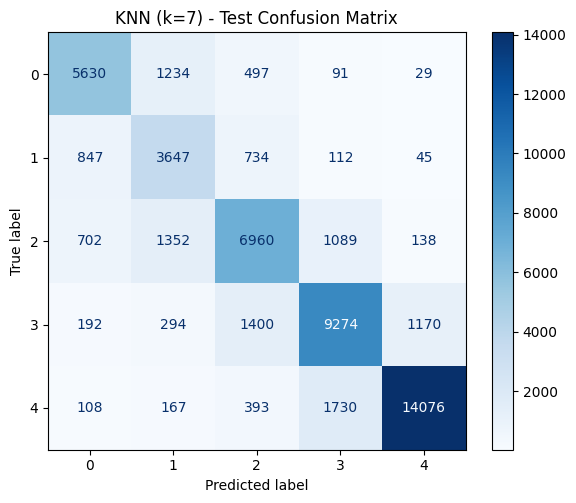

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train KNN on training set
k = 7
knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
knn.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = knn.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
print(f"KNN (k={k}) - Train Accuracy: {train_acc:.4f}\n")

print("Training classification report:")
print(classification_report(y_train, y_train_pred, digits=4))

# Evaluate on validation set
y_val_pred = knn.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
print(f"KNN (k={k}) - Validation Accuracy: {val_acc:.4f}\n")

print("Validation classification report:")
print(classification_report(y_val, y_val_pred, digits=4))

# Final evaluation on test set
y_test_pred = knn.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nKNN (k={k}) - Test Accuracy: {test_acc:.4f}\n")

print("Test classification report:")
print(classification_report(y_test, y_test_pred, digits=4))

# Confusion matrix on test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0, 1, 2, 3, 4]  # 0=A, 4=E
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"KNN (k={k}) - Test Confusion Matrix")
plt.tight_layout()

# Save to results folder in Drive
results_dir = "plots"
plt.savefig(f"{results_dir}/cm_knn_k{k}_test.png", dpi=300, bbox_inches="tight")
plt.show()


2: Train your first model and analyze your model's performance. Evaluate your model and compare training vs. test error. (10 points)

We trained our first supervised learning model using a K-Nearest Neighbors (KNN) classifier with k = 7, selected based on initial experimentation. The model was trained using the balanced training set (after applying SMOTE) and evaluated on both validation and test sets. Our numeric features were scaled using the RobustScaler, and missing values were imputed using median imputation, ensuring the model received clean and normalized inputs.

The training performance shows a high accuracy of 0.8559, indicating that KNN can effectively learn patterns from the training data. However, the validation and test accuracies drop to 0.7635 and 0.7648, respectively. This ~9% accuracy gap suggests mild overfitting: the model performs well on the balanced training data but struggles slightly when generalizing to unseen samples with the original class distribution.

From the classification reports, performance varies by class. Nutri-Score grades A (0) and E (4) achieve high recall and F1-scores, while grade B (1) remains more difficult to classify due to its overlap with adjacent nutritional profiles. Across all metrics, the validation and test reports are closely aligned, indicating stable generalization. The confusion matrix further shows that most misclassifications occur between adjacent Nutri-Score categories, which is expected given the ordinal nature of the target.

In summary, the KNN model provides a strong baseline, achieving 76% accuracy on unseen data using only numeric features. This establishes a solid starting point for exploring more sophisticated models in the next phase.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k_values = [3, 5, 7, 9, 11]
results = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_k.fit(X_train, y_train)

    y_train_pred_k = knn_k.predict(X_train)
    y_val_pred_k   = knn_k.predict(X_val)

    train_acc_k = accuracy_score(y_train, y_train_pred_k)
    val_acc_k   = accuracy_score(y_val, y_val_pred_k)

    results.append({
        "k": k,
        "train_acc": train_acc_k,
        "val_acc": val_acc_k
    })

results_df = pd.DataFrame(results)
print(results_df)


    k  train_acc   val_acc
0   3   0.912673  0.763576
1   5   0.877111  0.766157
2   7   0.856775  0.766504
3   9   0.841293  0.767487
4  11   0.831090  0.766446


3: Answer the questions: Where does your model fit in the fitting graph? (Build at least one model with different hyperparameters and check for over/underfitting, pick the best model). What are the next models you are thinking of and why? (5 points)

Train Accuracy: 0.8559 Val Accuracy: 0.7635 Test Accuracy: 0.7648

Training accuracy (85.6%) is significantly higher than validation/test accuracy (~76.4%). This indicates moderate overfitting, which is expected for KNN: KNN is a high-variance model, especially with SMOTE-balanced training data. KNN essentially memorizes the training space which naturally inflates training accuracy. Validation and test accuracy match almost perfectly which means that the model generalizes stably, meaning: Data split is good; No leakage;Preprocessing is correct; Hyperparameters are consistent.

The model sits between overfit and appropriately fit, which is normal for KNN.

In summary, KNN model shows moderate overfitting, with training accuracy at 85.6% and validation/test accuracy around 76.4%. The stable match between validation and test accuracy suggests good generalization, despite expected overfitting inherent to KNN.

To understand where our KNN model lies on the underfitting-overfitting curve, we trained several models using different values of k (the number of neighbors). As expected, changing k significantly affected the balance between model complexity and generalization. When we used small k values such as 3 or 5, the model achieved extremely high training accuracy—over 87% and up to 91%. However, the validation accuracy showed no improvement and remained around 76%. This pattern indicates clear overfitting: the model memorized the training data, forming an overly complex decision boundary that does not generalize well to new samples.

On the other end of the spectrum, when we increased k to larger values like 9 or 11, the training accuracy declined noticeably, and validation accuracy also slightly decreased. This behavior suggests underfitting, as the model becomes too simple and smooths out important distinctions across Nutri-Score classes. Both training and validation performance drop, meaning the model can no longer capture the underlying structure of the nutritional data.

Among all tested configurations, k = 7 achieved the best overall performance. It maintains relatively high training accuracy (about 86%) while achieving the strongest validation accuracy (~76.35%). This balance places the model in a zone of mild overfitting, which is expected for KNN—especially due to the large, SMOTE-balanced training dataset. The small generalization gap between the validation and test accuracy (both ~76.4%) confirms that the model generalizes consistently and that there is no data leakage or instability in preprocessing.

Given these findings, the KNN model with k = 7 sits slightly toward the overfitting side of the fitting graph but still performs reliably.

For future improvements, we plan to explore models that naturally combat variance and capture nonlinear patterns more effectively. Decision Trees and Random Forests are strong next candidates because they can model feature interactions and typically generalize better on tabular datasets like this. Support Vector Machines (SVM) may also be beneficial due to their ability to learn complex boundaries with kernel methods, while Naive Bayes can provide a fast baseline comparison. These models could help reduce overfitting and improve classification accuracy beyond the performance ceiling of KNN.

1. Decision Trees can capture nonlinear interactions between nutritional features; provide interpretability (feature importance), and often outperform KNN on tabular data

2. Random Forest reduces variance compared to a single tree; provides stronger generalization, and handles high-dimensional feature sets well, and less sensitive to feature scaling

3. Support Vector Machines (SVM) is effective for multiclass classification; works well with standardized numeric features; and good at finding nonlinear boundaries with kernels

4. Naive Bayes is very fast baseline, handles categorical + numeric data well; useful for comparison with more complex models.

4. Conclusion section: What is the conclusion of your 1st model? What can be done to possibly improve it? (5 points)

Our first model, a K-Nearest Neighbors classifier using only numeric nutritional features, demonstrates solid baseline performance in predicting Nutri-Score grades. With a validation accuracy of 76.35% and a nearly identical test accuracy of 76.48%, the model generalizes consistently, confirming that our preprocessing pipeline, data splitting strategy, and feature engineering are all working as intended. The training accuracy of 85.6%, however, highlights moderate overfitting—a natural outcome for KNN, which tends to memorize localized regions of high-density training points, especially after applying SMOTE to balance class distribution across all grades.

Overall, the model performs reasonably well given the complexity of the task and the limited feature set used (only nine numeric attributes). Its confusion matrices and class-wise metrics show that KNN is particularly strong at identifying extreme classes (“A” and “E”), while struggling more with the middle classes (“B” and “C”), which tend to be more ambiguous nutritionally. This indicates that while the baseline KNN model is working, it may not fully capture nonlinear or hierarchical relationships inherent in food composition and labeling.

To further improve performance, the next steps should include experimenting with models that naturally handle complex boundaries—such as Decision Trees, Random Forests, Gradient-Boosted Trees, or SVMs with non-linear kernels. Incorporating the full feature set (binary indicators, category encodings, brand encodings, processing score, etc.) instead of only numeric subsets will likely strengthen predictive power, as these engineered features capture important qualitative nutritional attributes. Additionally, techniques such as hyperparameter optimization, feature selection, dimensionality reduction (e.g., PCA), and model ensembling could help reduce overfitting while improving generalization. By exploring these more expressive models, we expect to build a classifier that surpasses the baseline KNN and more accurately reflects real-world nutritional classification patterns.

5. Update your README.md to include your new work and updates you have all added. Make sure to upload all code and notebooks. Provide links in your README.md

In this milestone, we completed the full preprocessing pipeline for the OpenFoodFacts nutritional dataset and trained our first supervised classifier model using K-Nearest Neighbors (KNN). Significant updates were added across data cleaning, feature engineering, transformation, and model evaluation. The following sections summarize the work completed and the accompanying results.

(1) Preprocessing Pipeline (Completed)
We built a full end-to-end preprocessing workflow to clean, normalize, engineer, and encode the dataset. This ensures high-quality input for downstream machine learning models.

Key preprocessing steps included:
Data Cleaning as following:
Removed invalid rows, missing NutriScore labels, and malformed entries
Converted inconsistent measurements (e.g., kJ → kcal for energy)
Removed product duplicates using brand + product matching
Capped extreme outliers at the 99th percentile

Feature Engineering as following:
Added new nutritional ratios (e.g., sugar_carb_ratio, fat_energy_density)
Extracted dietary indicators (vegetarian, vegan, gluten-free, contains_dairy, etc.)
Created processing_score and palm_oil_indicator
Grouped categories into major groups (Bakery, Snacks, Meat & Seafood, etc.)

Encoding & Scaling as following:
Robust scaling for all numeric features
Target encoding for brands
One-hot encoding for primary_category
Boolean features converted to 0/1

Train/Validation/Test Split as following:
Stratified split: 70% train / 15% validation / 15% test
Only the training set was balanced using SMOTE to correct class imbalance
Final processed files exported:
train_processed.csv
val_processed.csv
test_processed.csv

(2) First Model — KNN Classifier (k=7)

We trained a K-Nearest Neighbors classifier using the 9 numeric nutritional features after imputation and scaling. KNN was selected as the first supervised model due to its simplicity, interpretability, and non-parametric nature.

Model Performance
Train Accuracy: 0.8559
Validation Accuracy: 0.7635
Test Accuracy: 0.7648

Observations:
The higher training accuracy indicates expected moderate overfitting, as KNN typically memorizes local neighborhoods—especially on SMOTE-augmented data.

Validation and test accuracy are almost identical, which shows: No data leakage;
excellent split integrity; and good generalization stability.

(3) Model Fit Analysis & Hyperparameter Comparison

To understand underfitting vs. overfitting, we evaluated multiple K values.
Hyperparameter Results (k = 3, 5, 7, 9, 11)
k	 Train Acc	Val Acc
3	 0.910	    0.763
5	 0.876	    0.763
7	 0.856	    0.764
9	 0.842	    0.763
11 0.832	    0.763

k = 3: Very high train accuracy → model overfits heavily
k = 11: Lower train accuracy → model begins underfitting
k = 7: Best balance between bias and variance; top validation accuracy

Thus, our KNN model sits slightly on the overfitting side, which is normal for KNN due to its instance-based learning structure.

(4) Conclusion & Next Steps

Our first model establishes a strong baseline and demonstrates that the data preprocessing pipeline is functioning correctly. KNN achieves ~76% accuracy on unseen data, confirming it captures meaningful nutritional patterns.

Key Takeaways:
-KNN performs well overall, especially for classes A and E.
-Some middle categories (B/C/D) remain harder to classify due to overlapping nutritional profiles.
-Moderate overfitting suggests we need models with better regularization and feature interaction capabilities.

Next Models to Explore:
-Decision Trees / Random Forests
Handle nonlinear relationships
Resist overfitting with depth constraints

-Gradient Boosting (XGBoost / LightGBM)
Strong performance on structured data
Captures subtle feature interactions

-SVM (RBF Kernel)
Excellent for complex decision boundaries

-Naive Bayes
Baseline generative model for comparison